# Pneumonia Prediction 


In [1]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
print(os.listdir("data/input/train"))

['PNEUMONIA', 'NORMAL']


## Define train and test local directories

In [2]:
TRAIN_DIR = "data/input/train/"
TEST_DIR =  "data/input/test/"

## Data preprocessing

In [3]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [6]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [7]:
X_train, y_train = get_data(TRAIN_DIR)


100%|██████████| 1341/1341 [07:21<00:00,  3.22it/s]


Labeled training data

In [8]:
X_test , y_test = get_data(TEST_DIR)


100%|██████████| 234/234 [01:27<00:00,  2.53it/s]


Labeled testing data

In [9]:
print(X_train.shape,'\n',X_test.shape)


(5216, 150, 150, 3) 
 (624, 150, 150, 3)


Display shape of train and test data

In [10]:
print(y_train.shape,'\n',y_test.shape)


(5216,) 
 (624,)


In [11]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

Using TensorFlow backend.


In [12]:
print(y_train.shape,'\n',y_test.shape)


(5216, 2) 
 (624, 2)


In [13]:
Pimages = os.listdir(TRAIN_DIR + "PNEUMONIA")
Nimages = os.listdir(TRAIN_DIR + "NORMAL")

In [14]:
import matplotlib.pyplot as plt
def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR+"PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(0,5):
    plotter(i)

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


<Figure size 1000x500 with 1 Axes>

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


<Figure size 1000x500 with 1 Axes>

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


<Figure size 1000x500 with 1 Axes>

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


<Figure size 1000x500 with 1 Axes>

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


<Figure size 1000x500 with 1 Axes>

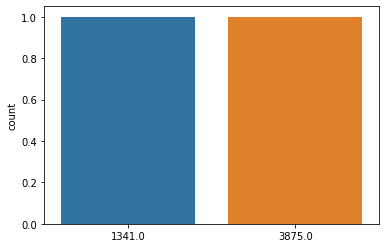

In [15]:
import seaborn as sns
count = y_train.sum(axis = 0)
sns.countplot(x = count)

The classes are imbalanced so let's look at confusion matrix for precision, recall details

In [16]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

/Users/ganagni/anaconda3/lib/python3.7/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Learning rate can be reduced using callbacks

In [17]:
filepath="weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

Timely checkpoint to save the model and also avoid overfitting

In [18]:
from keras.models import Sequential
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [19]:
X_train=X_train.reshape(5216,3,150,150)
X_test=X_test.reshape(624,3,150,150)

In [20]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(2 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.00005),
                  metrics=['accuracy'])

print(model.summary())

W0921 19:31:35.904768 4460230080 deprecation_wrapper.py:119] From /Users/ganagni/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0921 19:31:35.931532 4460230080 deprecation_wrapper.py:119] From /Users/ganagni/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0921 19:31:35.933527 4460230080 deprecation_wrapper.py:119] From /Users/ganagni/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0921 19:31:35.943428 4460230080 deprecation_wrapper.py:119] From /Users/ganagni/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instea

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 75, 75)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 75, 75)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 75, 75)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 37, 37)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 37, 37)        18496     
__________

In [21]:
batch_size = 256
epochs = 6

In [22]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Train on 5216 samples, validate on 624 samples
Epoch 1/6
5216/5216 [==============================] - 161s 31ms/step - loss: 0.5712 - acc: 0.7408 - val_loss: 0.6530 - val_acc: 0.6250

Epoch 00001: val_acc improved from -inf to 0.62500, saving model to weights.hdf5
Epoch 2/6
5216/5216 [==============================] - 159s 31ms/step - loss: 0.3725 - acc: 0.8367 - val_loss: 0.7368 - val_acc: 0.6571

Epoch 00002: val_acc improved from 0.62500 to 0.65705, saving model to weights.hdf5
Epoch 3/6
5216/5216 [==============================] - 159s 31ms/step - loss: 0.2913 - acc: 0.8881 - val_loss: 0.7420 - val_acc: 0.6803

Epoch 00003: val_acc improved from 0.65705 to 0.68029, saving model to weights.hdf5
Epoch 4/6
5216/5216 [==============================] - 160s 31ms/step - loss: 0.2600 - acc: 0.9012 - val_loss: 0.8097 - val_acc: 0.6595

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00004: val_acc did not improve from 0.68029
Epoch 5/6
5216/5216 [====

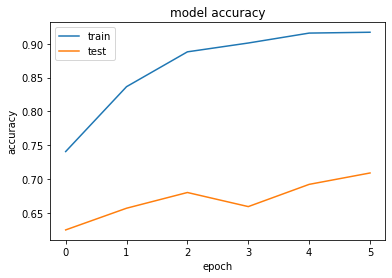

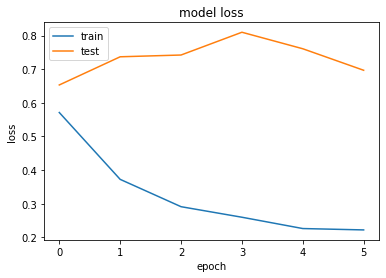

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model will try to overfit and necessary callbacks saved the models

In [24]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

In [ ]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

For quick implementation of confusion matrix, mixtend is used

## Precision - 69.41%

In [26]:
370 / (370 + 163)


0.6941838649155723

## Recall - 94.87%

In [30]:
370/(370+20)

0.9487179487179487